In [1]:
import time
import numpy as np
from scipy import linalg as LA
from matplotlib import pyplot as plt
%matplotlib inline

## Helper Functions

In [2]:
def smart_eigh(A, B, **kargs):
    block_size = B.shape[0]
    return LA.eigh(A, B + np.eye(block_size) * 1e-10, **kargs)

In [3]:
def get_gaussian_kernel(X, gamma):
    N = X.shape[0]
    K = np.zeros((N, N))
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K[i, j] = np.exp(-(1/gamma**2) * LA.norm(X[i] - X[j])**2)
    return K

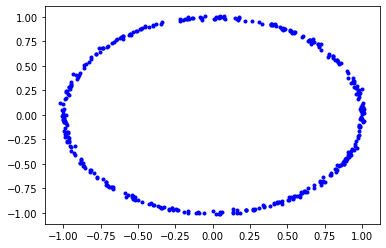

In [4]:
N = 400
sigma = 0.01
t = np.random.uniform(0, 2 * np.pi, size=(N, 1))
n1 = np.random.normal(0, sigma, (N, 1))
n2 = np.random.normal(0, sigma, (N, 1))
X = np.sin(t) + n1 # (N, 1)
Y = np.cos(t) + n2 # (N, 1)
plt.plot(X, Y, "b.")
gamma = 1
eta = 1e-4

K = get_gaussian_kernel(X, gamma) # (N, N)
L = get_gaussian_kernel(Y, gamma) # (N, N)
H = np.eye(N) - np.ones(N) / N
Ktilde = H @ K @ H # (N, N)
Ltilde = H @ L @ H # (N, N)
Z = np.zeros((N, N))

A = np.block([
    [Z, (1/N * Ktilde @ Ltilde)],
    [(1/N * Ltilde @ Ktilde), Z]
])

B = np.block([
    [Ktilde, Z],
    [Z, Ltilde]
])

In [5]:
def get_exact_COCO():
    N = X.shape[0]
    
    # A @ v = gamma * B @ v
    # alpha 
    # K~ -> A
    
    eigvals, eigvecs = smart_eigh(A, B)

    coco = np.abs(np.real(eigvals.max()))

    alpha = np.sqrt(2) * eigvecs[0:N, -1]
    beta = np.sqrt(2) * eigvecs[N:(2*N), -1]
    
    assert coco == eigvals[-1]
    assert np.allclose(alpha.T @ Ktilde @ alpha, 1)
    assert np.allclose(beta.T @ Ltilde @ beta, 1)

    f = K @ H @ alpha
    g = L @ H @ beta

    return f, g, coco
tic = time.perf_counter()
f_exact, g_exact, coco_exact = get_exact_COCO()
print("Took", time.perf_counter() - tic)

Took 0.1179469310445711


In [6]:
def incomplete_cholesky_decomposition(K, eta):
    l = K.shape[0]
    j = 0
    R = np.zeros((l, l))
    d = K.diagonal().copy()

    a, I_jplus1 = d.max(), d.argmax()
    I = [I_jplus1]
    nu = []
    while a > eta:
        nu.append(np.sqrt(a))
        for i in range(l):
            R[j, i] = 1/nu[j] * (K[I[j], i] - R[:, i].T @ R[:, I[j]])
            d[i] = d[i] - R[j, i] ** 2
        a, I_jplus1 = d.max(), d.argmax()
        I += [I_jplus1]
        j += 1
    T = j
    R = R[0:T, :]
    return R

def get_efficient_COCO():
    N = X.shape[0]
    eta = 1e-5
    
    R = incomplete_cholesky_decomposition(B, eta)
#     assert R.shape == B.shape
    Atilde = LA.pinv(R.T) @ A @ LA.pinv(R)
    eigvals, eigvecs = LA.eigh(Atilde)
    
    coco = eigvals[-1]
    
    eigvecs_reg = LA.pinv(R) @ eigvecs[:, -1]
#     coco = np.abs(np.real(eigvecs_reg.max())) # doesn't match
    alpha = np.sqrt(2) * eigvecs_reg[N:(2*N)]
    beta = np.sqrt(2) * eigvecs_reg[0:N]

    assert np.allclose(alpha.T @ Ktilde @ alpha, 1, atol=2e-1), alpha.T @ Ktilde @ alpha
    assert np.allclose(beta.T @ Ltilde @ beta, 1, atol=2e-1), beta.T @ Ltilde @ beta
    
    f = K @ H @ alpha
    g = L @ H @ beta

    return f, g, coco

tic = time.perf_counter()
f_eff, g_eff, coco_eff = get_efficient_COCO()
print("Took", time.perf_counter() - tic)

Took 0.08573840500321239


Exact COCO: 0.0909963, Efficient COCO: 0.0909963


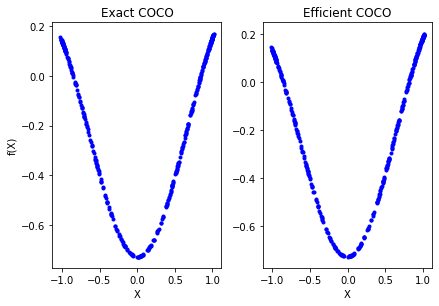

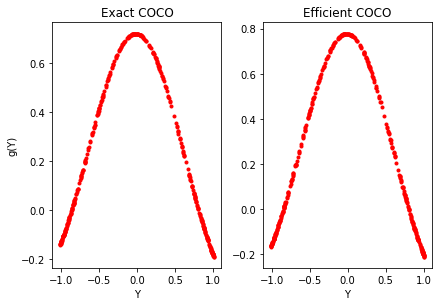

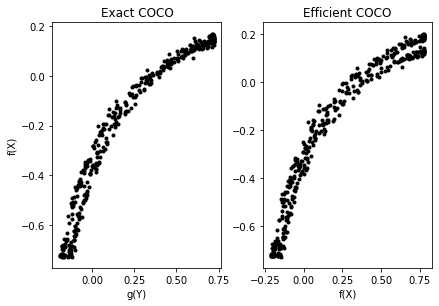

In [7]:
print("Exact COCO: {:.7f}, Efficient COCO: {:.7f}".format(coco_exact, coco_eff))

fig, axs = plt.subplots(1, 2)
fig.tight_layout()
axs[0].plot(X, f_exact, "b.")
axs[0].set_title("Exact COCO")
axs[0].set_xlabel("X")
axs[0].set_ylabel("f(X)")
axs[1].plot(X, f_eff, "b.")
axs[1].set_title("Efficient COCO")
axs[1].set_xlabel("X")

plt.show()
fig, axs = plt.subplots(1, 2)
fig.tight_layout()
axs[0].plot(Y, g_exact, "r.")
axs[0].set_title("Exact COCO")
axs[0].set_xlabel("Y")
axs[0].set_ylabel("g(Y)")
axs[1].plot(Y, g_eff, "r.")
axs[1].set_title("Efficient COCO")
axs[1].set_xlabel("Y")
plt.show()

fig, axs = plt.subplots(1, 2)
fig.tight_layout()
axs[0].plot(g_exact, f_exact, "k.")
axs[0].set_title("Exact COCO")
axs[0].set_xlabel("g(Y)")
axs[0].set_ylabel("f(X)")
axs[1].plot(g_eff, f_eff, "k.")
axs[1].set_title("Efficient COCO")
axs[1].set_xlabel("f(X)")
plt.show()


In [8]:
def get_kernel_cca():
    N = X.shape[0]
    
    reg = 1e-1

    A = np.block([
        [Z, (1/N * Ktilde @ Ltilde)],
        [(1/N * Ltilde @ Ktilde), Z]
    ])

    B = np.block([
        [Ktilde @ Ktilde + reg * Ktilde, Z],
        [Z, Ltilde @ Ltilde + reg * Ltilde]
    ])
    
    eigvals, eigvecs = smart_eigh(A, B)
        
    assert eigvals[-1] == eigvals.max()
    cca = eigvals[-1] * N
    
    alpha = np.sqrt(2) * np.sqrt(N) * eigvecs[0:N, -1]
    beta = np.sqrt(2) * np.sqrt(N) * eigvecs[N:(2*N), -1]
#     print(1/N * alpha.T @ Ktilde @ Ktilde @ alpha + reg * alpha.T @ Ktilde @ alpha)
    assert np.allclose(1/N * alpha.T @ Ktilde @ Ktilde @ alpha, 1, atol=1e-1), 1/N * alpha.T @ Ktilde @ Ktilde @ alpha
    assert np.allclose(1/N * beta.T @ Ltilde @ Ltilde @ beta, 1, atol=1e-1), 1/N * beta.T @ Ktilde @ Ktilde @ beta

    f = K @ H @ alpha
    g = L @ H @ beta
    
    return f, g, cca
tic = time.perf_counter()
f_cca, g_cca, cca = get_kernel_cca()
print("Took", time.perf_counter() - tic)

Took 0.13374300801660866


CCA 0.9931417568172212


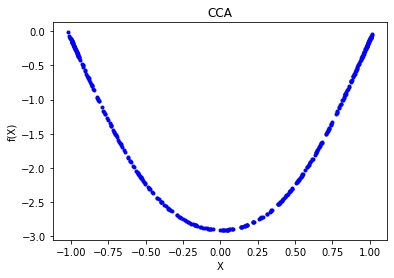

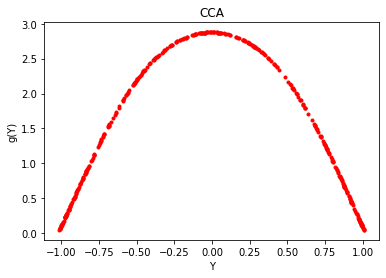

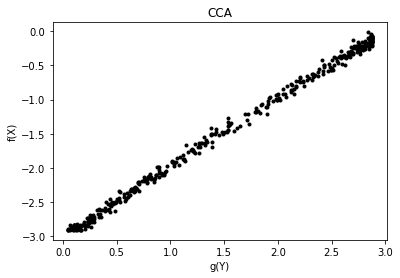

In [12]:
print("CCA", cca)

plt.title("CCA")
plt.plot(X, f_cca, "b.")
plt.xlabel("X")
plt.ylabel("f(X)")
plt.show()

plt.title("CCA")
plt.plot(Y, g_cca, "r.")
plt.xlabel("Y")
plt.ylabel("g(Y)")
plt.show()

plt.title("CCA")
plt.plot(g_cca, f_cca, "k.")
plt.xlabel("g(Y)")
plt.ylabel("f(X)")
plt.show()